<a href="https://colab.research.google.com/github/Xiaohei-dsy/Sentiment-Analysis-System/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 597ML Final Project
### Fine-Tuning BERT for Pun Classification

**By Dhruv, Chenkai and Shouyou**

> ### Introduction
For this project, we used a form of the SemeVal 2017 Task 3 Dataset of Puns [SemeVal 2017 Task 7 Dataset of Puns](https://alt.qcri.org/semeval2017/task7/). We used a modified version of this dataset, that was in a TSV form instead of XML found [here](https://github.com/qiwei-404/masked-pun-detector-with-bert/blob/master/data/base/test.tsv). We will be fine-tuning the BERT for classifying puns using this generated dataset. Google Drive Link: https://drive.google.com/file/d/1q1yx0tqN8339fjMGmbKKOWADLylSwANY/view?usp=sharing


## Section 0: Download Dataset and Install Prerequisites
Run this everytime you set up a new Colab environment...

In [ ]:
# Download dataset

# File ID = 1SLDAviAeuzGXJrEKuxI5tGvU0X2NjLap
# ^ Where the file is available (Google Drive link)
# ! gdown 1SLDAviAeuzGXJrEKuxI5tGvU0X2NjLap
! gdown 1q1yx0tqN8339fjMGmbKKOWADLylSwANY

Downloading...
From: https://drive.google.com/uc?id=1q1yx0tqN8339fjMGmbKKOWADLylSwANY
To: /content/test.tsv
100% 129k/129k [00:00<00:00, 51.7MB/s]


In [ ]:
# Run only during launch
! pip install transformers
! pip install -q tf-models-official==2.7.0
! pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.0 MB 9.5 MB/s 
     |████████████████████████████████| 77 kB 795 kB/s 
     |████████████████████████████████| 880 kB 36.3 MB/s 
     |████████████████████████████████| 6.6 MB 45.0 MB/s 
     |████████████████████████████████| 596 kB 10.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d2c5a85dab84e1f3fffe39f1d4adb28aeb77652f6a08b372f81bab5baab82f18
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.8 MB 12.8 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 352 kB 43.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████|

## Section 1: Load & Pre-Processing Data

In [ ]:
import os
import shutil

import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
data = pd.read_csv('test.tsv', sep='\t')
data.to_csv('test.csv')

In [ ]:
# Load into Pandas dataframe
path = 'test.csv'
df = pd.read_csv(path)
df = df.drop(columns=['ID'])
df.head()

,Unnamed: 0,Joke,Pun
0,0,"' ' I ' m halfway up a mountain , ' ' Tom alle...",1
1,1,"I ' d like to be a Chinese laborer , said Tom ...",1
2,2,"No , baby oil does NOT come from squeezing dea...",0
3,3,Dentists don ' t like a hard day at the orifice .,1
4,4,Are evil wildebeests bad gnus ?,1


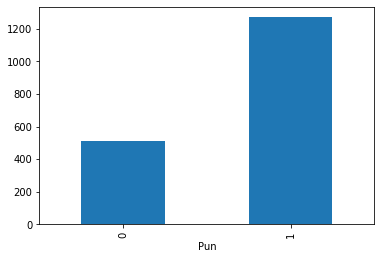

In [ ]:
# Plot the dataset, to show proportion of puns vs non-puns
df.groupby(['Pun']).size().plot.bar()

In [ ]:
# Split dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Joke'], 
                                                    df['Pun'], 
                                                    stratify=df['Pun'], 
                                                    shuffle=True, 
                                                    random_state=42, 
                                                    train_size=0.7)

## Section 2: Creating BERT Layers and Model

In [ ]:
# Downloading the BERT Preprocessor and Encoder from TensorFlow Hub
# Link for BERT Models: https://tfhub.dev/google/collections/bert/1

bert_preprocessor= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Input Layer > Preprocess Layer > BERT Layer > Dropout > Classifier

input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
pre_processed_text = bert_preprocessor(input)
bert_outputs = bert_model(pre_processed_text)
net = bert_outputs['pooled_output']
dropout_layer = tf.keras.layers.Dropout(0.1)(net)
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout_layer)

# Combine Layers to make final model
model = tf.keras.Model(inputs=[input], outputs = [output])

In [ ]:
# Compile and fit model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split = 0.1, epochs=10, batch_size = 32)

Epoch 1/10
36/36 [==============================] - 34s 681ms/step - loss: 0.6584 - accuracy: 0.6557 - val_loss: 0.6354 - val_accuracy: 0.6640
Epoch 2/10
36/36 [==============================] - 24s 661ms/step - loss: 0.5536 - accuracy: 0.7217 - val_loss: 0.5505 - val_accuracy: 0.7440
Epoch 3/10
36/36 [==============================] - 24s 662ms/step - loss: 0.5157 - accuracy: 0.7422 - val_loss: 0.5497 - val_accuracy: 0.6880
Epoch 4/10
36/36 [==============================] - 24s 661ms/step - loss: 0.4988 - accuracy: 0.7395 - val_loss: 0.5198 - val_accuracy: 0.7200
Epoch 5/10
36/36 [==============================] - 24s 661ms/step - loss: 0.4786 - accuracy: 0.7600 - val_loss: 0.4935 - val_accuracy: 0.7360
Epoch 6/10
36/36 [==============================] - 24s 664ms/step - loss: 0.4684 - accuracy: 0.7591 - val_loss: 0.4708 - val_accuracy: 0.7520
Epoch 7/10
36/36 [==============================] - 24s 664ms/step - loss: 0.4593 - accuracy: 0.7806 - val_loss: 0.4897 - val_accuracy: 0.7280

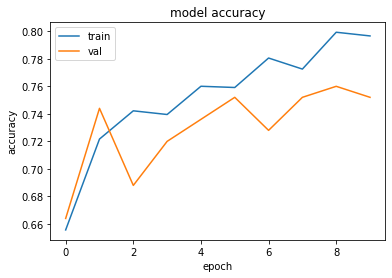

In [ ]:
# Plot Validation and Test Accuracy
from matplotlib import pyplot as plt

# Plot the trends
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Labels
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
# Evaluate the model on test data
# model.evaluate(X_test, y_test)
y_pre = model.predict(X_test)
y_true = np.asarray(y_test, dtype = 'float32')

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Use Sklearn Metrics to Calculate F1, Recall and Precision Scores
y_pre = np.where(y_pre >= 0.5, 1, 0) # convert y_pre to the same format as y_true
print("---BERT Classifier---\nprecision：%s \nrecall：%s \nf1：%s" % (precision_score(y_true, y_pre), recall_score(y_true, y_pre), f1_score(y_true, y_pre))) 

---BERT Classifier---
precision：0.7838983050847458 
recall：0.9711286089238845 
f1：0.8675263774912075


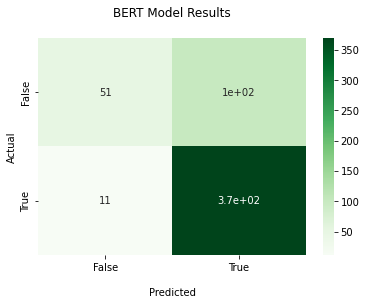

In [ ]:
# --- PLOT CONFUSION MATRIX ---

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cfm = confusion_matrix(y_true, y_pre)

# Plot the confusion matrix
plot = sns.heatmap(cfm, annot=True, cmap='Greens')

# Set labels and titles
plot.set_title('BERT Model Results\n');
plot.set_xlabel('\nPredicted')
plot.set_ylabel('Actual');

# Set axis titles
plot.xaxis.set_ticklabels(['False','True'])
plot.yaxis.set_ticklabels(['False','True'])

plt.show()

## Section 3: Simpler Models


### SVM Classifier

In [ ]:
# Imports to make a test SVM Classifier
from sklearn import svm
from sklearn.pipeline import Pipeline

# Count Vectorizer to vectorize words in text (preprocessing)
from sklearn.feature_extraction.text import CountVectorizer

# Create Pipeline with Vectorizer > SVM/SVC
svm_clf = Pipeline([('vectorizer', CountVectorizer()), ('svm', svm.SVC())])

# Use Grid Search to FInd Best Parameters
from sklearn.model_selection import GridSearchCV
param_grid = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
              'svm__kernel': ('linear', 'rbf'),
              'svm__C': (0.1, 1, 10, 100)}
gscv = GridSearchCV(svm_clf, param_grid, n_jobs=-1)

# Fit and print results
results = gscv.fit(X_train, y_train)
results.best_params_

{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__ngram_range': (1, 2)}

In [ ]:
# Create classifier with best parameters
from sklearn.metrics import f1_score, recall_score, precision_score
svm_clf = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 2))), 
                    ('svm', svm.SVC(kernel='linear', C=1))])

# Fit to Training Data
svm_clf.fit(X_train, y_train)

# Use Sklearn Metrics to Calculate F1, Recall and Precision Scores
y_pre = svm_clf.predict(X_test)
y_true = np.asarray(y_test, dtype = 'float32')
print("---SVM Classifier---\nprecision：%s \nrecall：%s \nf1：%s" % (precision_score(y_true, y_pre), recall_score(y_true, y_pre), f1_score(y_true, y_pre))) 

---SVM Classifier---
precision：0.8630490956072352 
recall：0.8766404199475065 
f1：0.8697916666666666


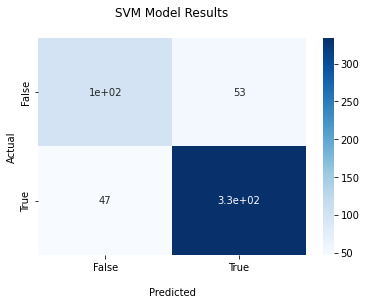

In [ ]:
# --- PLOT CONFUSION MATRIX ---
import matplotlib.pyplot as plt
# Create confusion matrix
cfm = confusion_matrix(y_test, y_pre)

# Plot the confusion matrix
plot = sns.heatmap(cfm, annot=True, cmap='Blues')

# Set labels and titles
plot.set_title('SVM Model Results\n');
plot.set_xlabel('\nPredicted')
plot.set_ylabel('Actual');

# Set axis titles
plot.xaxis.set_ticklabels(['False','True'])
plot.yaxis.set_ticklabels(['False','True'])

plt.show()

### Naive Bayes Classifier

In [ ]:
# Imports to make a test Naive Bayes Classifier Classifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

# Create Pipeline with Vectorizer > Naive Bayes
nb_clf = Pipeline([('vectorizer', CountVectorizer()), ('naive_bayes', MultinomialNB())])

# Use Grid Search to FInd Best Parameters
param_grid = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 
              'naive_bayes__alpha': (0.001, 0.01, 0.1, 1),
              'naive_bayes__fit_prior': (True, False)}
gscv = GridSearchCV(nb_clf, param_grid, n_jobs=-1)

# Fit and print results
results = gscv.fit(X_train, y_train)
results.best_params_

{'naive_bayes__alpha': 1,
 'naive_bayes__fit_prior': False,
 'vectorizer__ngram_range': (1, 2)}

In [ ]:
# Create classifier with best parameters
nb_clf = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 2))), ('naive_bayes', MultinomialNB(fit_prior=False, alpha=0.01))])

# Fit to Training Data
nb_clf.fit(X_train, y_train)

# Use Sklearn Metrics to Calculate F1, Recall and Precision Scores
y_pre = nb_clf.predict(X_test)
print("---Naive Bayes Classifier---\nprecision：%s \nrecall：%s \nf1：%s" % (precision_score(y_true, y_pre), recall_score(y_true, y_pre), f1_score(y_true, y_pre))) 

---Naive Bayes Classifier---
precision：0.8337468982630273 
recall：0.8818897637795275 
f1：0.857142857142857


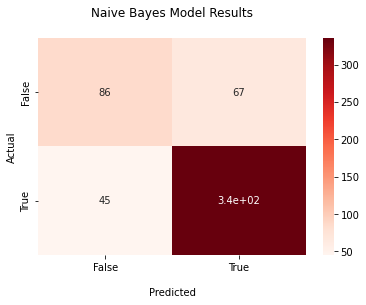

In [ ]:
# --- PLOT CONFUSION MATRIX ---

# Create confusion matrix
cfm = confusion_matrix(y_test, y_pre)

# Plot the confusion matrix
plot = sns.heatmap(cfm, annot=True, cmap='Reds')

# Set labels and titles
plot.set_title('Naive Bayes Model Results\n');
plot.set_xlabel('\nPredicted')
plot.set_ylabel('Actual');

# Set axis titles
plot.xaxis.set_ticklabels(['False','True'])
plot.yaxis.set_ticklabels(['False','True'])

plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html BERT.ipynb

[NbConvertApp] Converting notebook BERT.ipynb to html
[NbConvertApp] Writing 394697 bytes to BERT.html
